In [1]:
import pymc3 as pm
import theano
import toytree
import pandas as pd
import numpy as np
import sproc

In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))

In [5]:
data

# Lit, biogeo need to be handled like county codes are in the example.

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,914,5995.0,MN,MN,27.0,55363,5.0,1.0,0.0,4.0,...,4.5,1146.499190,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.871802
915,915,5996.0,MN,MN,27.0,55376,5.0,1.0,0.0,7.0,...,8.3,1105.956867,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.526056
916,916,5997.0,MN,MN,27.0,55376,5.0,1.0,0.0,4.0,...,5.2,1214.922779,0.0,0.0,171.0,WRIGHT,27171.0,0.913909,83,1.629241
917,917,5998.0,MN,MN,27.0,56297,5.0,1.0,0.0,4.0,...,9.6,1177.377355,0.0,0.0,173.0,YELLOW MEDICINE,27173.0,1.426590,84,1.335001


## What goes into a hierarchical linear model for oak RI?

Y is RI and what we want to determine.  The censored model means Y must be between 0 and 1.

X is genetic distance.  For all pairs, calculate genetic distance on toytree objeect.

B1 (a) is slope: normal prior, mu = 0 and sigma = 5.

B0 (b) is intercept: normal prior mu = 0 and sigma = 1.

C values combine additively with B1: normal prior, mu = 0 and sigma = 1.  Like slope and intercept, I don't know these in advance but I can use priors to guess at what they should be.

Error term: lognormal prior, log mean = -1 and log SD = 1.

*The simplest output is a traceplot distribution, but ultimately I want values assinged to a heatmap.  To do that, get MAP values for each pair.*

*On the heatmap, we have RI = 0 to denote complete compatibility and 1 for the opposite.  The biogeo and lit params should follow: 0 for overlapping/recorded, 1 for not overlapping/not recorded.*

## Organize parts of model from tree

The tutorial includes an "observed" argument: the radon data already known.  The analogue for oak hybrids would be previously known hybrid pair data, from the generative model.

The model will have two additional binary parameters: geographic range overlap (from sproc), and literature record of hybrid evidence.

By default, the model will try to assign a unique C value per species.  To constrain by clade (or entire dataset), I need to index clades and have that be part of the normal prior that sets up the distribution.  I would also need a shape argument for slope/intercept: number of clades.

## Tree and dataframe setup

In [2]:
# Load tree; drop outgroups, duplicates and tips with no data; and show tip labels.
tree = toytree.tree("/home/henry/oaks-thesis/moto/newick-cal-crown-lambda0_basic_scaffold05.tree")
atree = tree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.laeta', 'Quercus|Lobatae|Erythromexicana|Q.conzattii',
                       'Quercus|Quercus|Leucomexicana|Q.arizonica', 'SRR5984321', 'SRR5632417', 'SRR5632562'])
btree = atree.drop_tips(wildcard = "Chrysolepis")
ctree = btree.drop_tips(wildcard = "Notholithocarpus")
dtree = ctree.drop_tips(wildcard = "Lithocarpus")
etree = dtree.drop_tips(wildcard = "SRR")
ftree = etree.drop_tips(wildcard = "reference")
gtree = ftree.drop_tips(names = ['Quercus|Quercus|Leucomexicana|Q.species', 'Quercus|Quercus|Roburoids|Q.vulcanica',
                                'Quercus|Quercus|Roburoids|Q.imeretina', 'Quercus|Virentes|nan|Q.sagraeana',
                                'Quercus|Lobatae|Erythromexicana|Q.lowilliamsii', 
                                 'Quercus|Lobatae|Agrifoliae|Q.oxyadenia', 'Quercus|Quercus|Roburoids|Q.kotschyana',
                                'Quercus|Quercus|Roburoids|Q.cedrorum', 'Quercus|Quercus|Dumosae|Q.pacifica',
                                 'Quercus|Lobatae|Erythromexicana|Q.sartorii',
                                'Quercus|Lobatae|Agrifoliae|Q.tamalpaiensis','Quercus|Lobatae|Agrifoliae|Q.shrevei',
                                 'Cerris|Cyclobalanopsis|Semiserrata|Q.litoralis', 
                                 'Cerris|Cyclobalanopsis|Acuta|Q.ciliaris', 'Cerris|Cyclobalanopsis|Acuta|Q.stewardiana',
                                'Cerris|Cyclobalanopsis|Semiserrata|Q.patelliformis',
                                'Cerris|Cyclobalanopsis|Glauca|Q.multinervis', 'Cerris|Ilex|Himalayansubalpine|Q.sp.nov.'])
gtree.get_tip_labels()

['Quercus|Quercus|Leucomexicana|Q.ajoensis',
 'Quercus|Quercus|Leucomexicana|Q.turbinella',
 'Quercus|Quercus|Leucomexicana|Q.toumeyi',
 'Quercus|Quercus|Leucomexicana|Q.oblongifolia',
 'Quercus|Quercus|Leucomexicana|Q.chihuahuensis',
 'Quercus|Quercus|Leucomexicana|Q.grisea',
 'Quercus|Quercus|Leucomexicana|Q.glaucoides',
 'Quercus|Quercus|Leucomexicana|Q.diversifolia',
 'Quercus|Quercus|Leucomexicana|Q.deserticola',
 'Quercus|Quercus|Leucomexicana|Q.peduncularis',
 'Quercus|Quercus|Leucomexicana|Q.obtusata',
 'Quercus|Quercus|Leucomexicana|Q.greggii',
 'Quercus|Quercus|Leucomexicana|Q.rugosa',
 'Quercus|Quercus|Leucomexicana|Q.glabrescens',
 'Quercus|Quercus|Leucomexicana|Q.striatula',
 'Quercus|Quercus|Leucomexicana|Q.potosina',
 'Quercus|Quercus|Leucomexicana|Q.purulhana',
 'Quercus|Quercus|Leucomexicana|Q.segoviensis',
 'Quercus|Quercus|Leucomexicana|Q.nudinervis',
 'Quercus|Quercus|Leucomexicana|Q.subspathulata',
 'Quercus|Quercus|Leucomexicana|Q.resinosa',
 'Quercus|Quercus|Leuc

In [3]:
gtree.draw(layout='r', scalebar=True);

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="te5a80f1dbac64f868a7e39379e9a9bb9" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 1000.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Quercus|Quercus|Leucomexicana|Q.ajoensis Quercus|Quercus|Leucomexicana|Q.turbinella Quercus|Quercus|Leucomexicana|Q.toumeyi Quercus|Quercus|Leucomexicana|Q.oblongifolia Quercus|Quercus|Leucomexicana|Q.chihuahuensis Quercus|Quercus|Leucomexicana|Q.grisea Quercus|Quercus|Leucomexicana|Q.glaucoides Quercus|Quercus|Leucomexicana|Q.diversifolia Quercus|Quercus|Leucomexicana|Q.deserticola Quercus|Quercus|Leucomexicana|Q.peduncularis Quercus|Quercus|Leucomexicana|Q.obtusata Quercus|Quercus|Leucomexicana|Q.greggii Quercus|Quercus|Leucomexicana|Q.rugosa Quercus|Quercus|Leucomexicana|Q.glabrescens Quercus|Quercus|Leucomexicana|Q.striatula Quercus|Quercus|Leucomexicana|Q.potosina Quercus|Quercus|Leucomexicana|Q.purulhana Quercus|Quercus|Leucomexicana|Q.segoviensis Quercus|Quercus|Leucomexicana|Q.nudinervis Quercus|Quercus|Leucomexicana|Q.subspathulata Quercus|Quercus|Leucomexicana|Q.resinosa Quercus|Quercus|Leucomexicana|Q.magnoliifolia Quercus|Quercus|Leucomexicana|Q.glaucescens Quercus|Quercus|Leucomexicana|Q.liebmanii Quercus|Quercus|Leucomexicana|Q.copeyensis Quercus|Quercus|Leucomexicana|Q.corrugata Quercus|Quercus|Leucomexicana|Q.insignis Quercus|Quercus|Leucomexicana|Q.lancifolia Quercus|Quercus|Leucomexicana|Q.germana Quercus|Quercus|Leucomexicana|Q.martinezii Quercus|Quercus|Stellatae|Q.stellata Quercus|Quercus|Stellatae|Q.boyntonii Quercus|Quercus|Stellatae|Q.similis Quercus|Quercus|Stellatae|Q.chapmanii Quercus|Quercus|Stellatae|Q.margarettae Quercus|Quercus|Stellatae|Q.austrina Quercus|Quercus|Stellatae|Q.oglethorpensis Quercus|Quercus|Stellatae|Q.havardii Quercus|Quercus|Stellatae|Q.sinuata Quercus|Quercus|Texaswhiteoaks|Q.pungens Quercus|Quercus|Texaswhiteoaks|Q.vaseyana Quercus|Quercus|Texaswhiteoaks|Q.hinckleyi Quercus|Quercus|Stellatae|Q.laceyi Quercus|Quercus|Texaswhiteoaks|Q.polymorpha Quercus|Quercus|Texaswhiteoaks|Q.mohriana Quercus|Quercus|Roburoids|Q.dalechampii Quercus|Quercus|Roburoids|Q.frainetto Quercus|Quercus|Roburoids|Q.pubescens Quercus|Quercus|Roburoids|Q.boissieri Quercus|Quercus|Roburoids|Q.infectoria Quercus|Quercus|Roburoids|Q.pyrenaica Quercus|Quercus|Roburoids|Q.macranthera Quercus|Quercus|Roburoids|Q.faginea Quercus|Quercus|Roburoids|Q.hartwissiana Quercus|Quercus|Roburoids|Q.lusitanica Quercus|Quercus|Roburoids|Q.canariensis Quercus|Quercus|Roburoids|Q.robur Quercus|Quercus|Roburoids|Q.petraea Quercus|Quercus|Roburoids|Q.fabri Quercus|Quercus|Roburoids|Q.aliena Quercus|Quercus|Roburoids|Q.griffithii Quercus|Quercus|Roburoids|Q.yunnanensis Quercus|Quercus|Roburoids|Q.serrata Quercus|Quercus|Roburoids|Q.dentata Quercus|Quercus|Roburoids|Q.mongolica Quercus|Quercus|Albae|Q.alba Quercus|Quercus|Albae|Q.michauxii Quercus|Quercus|Albae|Q.montana Quercus|Quercus|Dumosae|Q.dumosa Quercus|Quercus|Dumosae|Q.cornelius-mulleri Quercus|Quercus|Dumosae|Q.john-tuckeri Quercus|Quercus|Dumosae|Q.douglasii Quercus|Quercus|Dumosae|Q.berberidifolia Quercus|Quercus|Dumosae|Q.durata Quercus|Quercus|Leucomexicana|Q.engelmannii Quercus|Quercus|Dumosae|Q.garryana Quercus|Quercus|Dumosae|Q.lobata Quercus|Quercus|Prinoids|Q.bicolor Quercus|Quercus|Prinoids|Q.lyrata Quercus|Quercus|Prinoids|Q.macrocarpa Quercus|Quercus|Prinoids|Q.muehlenbergii Quercus|Quercus|Prinoids|Q.prinoides Quercus|Virentes|nan|Q.fusiformis Quercus|Virentes|nan|Q.minima Quercus|Ponticae|nan|Q.pontica Quercus|Ponticae|nan|Q.sadleriana Quercus|Protobalanus|nan|Q.chrysolepis Quercus|Protobalanus|nan|Q.tomentella Querc

In [4]:
# Function to get genetic distance on tree.
def dist(tree, idx0, idx1):

    # I only want to pass tips to this function, not internal nodes.
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [5]:
# Get a list of every possible pair of tips.
from itertools import combinations
tips = [idx for idx in gtree.get_node_dict().keys()]
pairs = list(combinations(tips, 2))

In [6]:
# Build dataframe.
df = pd.DataFrame(columns = ['Pairs', 'Range_pairs', 'Species1', 'Species2', 'Clades', 'Clade_index', 
                             'Overlap', 'Lit', 'GD', 'Observed_RI'])
df['Pairs'] = pairs
df

,Pairs,Range_pairs,Species1,Species2,Clades,Clade_index,Overlap,Lit,GD,Observed_RI
0,"(215, 214)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(215, 213)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(215, 212)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(215, 211)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(215, 210)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23215,"(3, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23216,"(3, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23217,"(2, 1)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23218,"(2, 0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Format species names.
df['Species1'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[3].split(".")[1]) for idx in df.index]
df['Species2'] = ["Quercus " + "{}".format(list(
    gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[3].split(".")[1]) for idx in df.index]

In [9]:
# Format clades.
df['Clades'] = ["{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][0]].split("|")[1]) + " + " +
        "{}".format(list(gtree.get_node_dict().values())[df.loc[idx, 'Pairs'][1]].split("|")[1])
        for idx in df.index]

In [10]:
# Set up clade duo index.
codes = dict(zip(df.Clades.unique(), range(len(df.Clades.unique()))))
df['Clade_index'] = [codes.get(df.loc[idx, "Clades"]) for idx in df.index]

## Biogeographic parameter

In [55]:
# List of names for GBIF querying.
names = ["Quercus " + "{}".format(list(gtree.get_node_dict().values())[idx].split("|")[3].split(".")[1]) for idx in tips]
len(names)

216

In [56]:
names

['Quercus ajoensis',
 'Quercus turbinella',
 'Quercus toumeyi',
 'Quercus oblongifolia',
 'Quercus chihuahuensis',
 'Quercus grisea',
 'Quercus glaucoides',
 'Quercus diversifolia',
 'Quercus deserticola',
 'Quercus peduncularis',
 'Quercus obtusata',
 'Quercus greggii',
 'Quercus rugosa',
 'Quercus glabrescens',
 'Quercus striatula',
 'Quercus potosina',
 'Quercus purulhana',
 'Quercus segoviensis',
 'Quercus nudinervis',
 'Quercus subspathulata',
 'Quercus resinosa',
 'Quercus magnoliifolia',
 'Quercus glaucescens',
 'Quercus liebmanii',
 'Quercus copeyensis',
 'Quercus corrugata',
 'Quercus insignis',
 'Quercus lancifolia',
 'Quercus germana',
 'Quercus martinezii',
 'Quercus stellata',
 'Quercus boyntonii',
 'Quercus similis',
 'Quercus chapmanii',
 'Quercus margarettae',
 'Quercus austrina',
 'Quercus oglethorpensis',
 'Quercus havardii',
 'Quercus sinuata',
 'Quercus pungens',
 'Quercus vaseyana',
 'Quercus hinckleyi',
 'Quercus laceyi',
 'Quercus polymorpha',
 'Quercus mohriana'

In [58]:
sproc.set_loglevel("INFO")

In [59]:
# Get occurrence data for species on tree.
ranges = [sproc.Sproc(species=spp, workdir="/tmp", scalar=2.5) for spp in names]

02:08 | INFO    | __init__        | fetched 39 occurrence records
02:08 | INFO    | _mark_outliers  | dropped outliers: 0
02:08 | INFO    | write           | wrote data to /tmp/Quercus_ajoensis.json
02:08 | INFO    | __init__        | fetched 1058 occurrence records
02:08 | INFO    | _mark_outliers  | dropped outliers: 37
02:08 | INFO    | write           | wrote data to /tmp/Quercus_turbinella.json
02:08 | INFO    | __init__        | fetched 177 occurrence records
02:08 | INFO    | _mark_outliers  | dropped outliers: 2
02:08 | INFO    | write           | wrote data to /tmp/Quercus_toumeyi.json
02:08 | INFO    | __init__        | fetched 302 occurrence records
02:08 | INFO    | _mark_outliers  | dropped outliers: 86
02:08 | INFO    | write           | wrote data to /tmp/Quercus_oblongifolia.json
02:09 | INFO    | __init__        | fetched 390 occurrence records
02:09 | INFO    | _mark_outliers  | dropped outliers: 99
02:09 | INFO    | write           | wrote data to /tmp/Quercus_chihua

02:11 | INFO    | _mark_outliers  | dropped outliers: 4
02:11 | INFO    | write           | wrote data to /tmp/Quercus_germana.json
02:11 | INFO    | __init__        | fetched 249 occurrence records
02:11 | INFO    | _mark_outliers  | dropped outliers: 1
02:11 | INFO    | write           | wrote data to /tmp/Quercus_martinezii.json
02:11 | INFO    | __init__        | fetched 914 occurrence records
02:11 | INFO    | _mark_outliers  | dropped outliers: 341
02:11 | INFO    | write           | wrote data to /tmp/Quercus_stellata.json
02:11 | INFO    | __init__        | fetched 7 occurrence records
02:11 | INFO    | _mark_outliers  | dropped outliers: 0
02:11 | INFO    | write           | wrote data to /tmp/Quercus_boyntonii.json
02:11 | INFO    | __init__        | fetched 19 occurrence records
02:11 | INFO    | _mark_outliers  | dropped outliers: 0
02:11 | INFO    | write           | wrote data to /tmp/Quercus_similis.json
02:11 | INFO    | __init__        | fetched 79 occurrence records
0

02:13 | INFO    | __init__        | fetched 3507 occurrence records
02:13 | INFO    | _mark_outliers  | dropped outliers: 3270
02:13 | INFO    | write           | wrote data to /tmp/Quercus_petraea.json
02:13 | INFO    | __init__        | fetched 916 occurrence records
02:13 | INFO    | _mark_outliers  | dropped outliers: 269
02:13 | INFO    | write           | wrote data to /tmp/Quercus_fabri.json
02:14 | INFO    | __init__        | fetched 1376 occurrence records
02:14 | INFO    | _mark_outliers  | dropped outliers: 1169
02:14 | INFO    | write           | wrote data to /tmp/Quercus_aliena.json
02:14 | INFO    | __init__        | fetched 172 occurrence records
02:14 | INFO    | _mark_outliers  | dropped outliers: 0
02:14 | INFO    | write           | wrote data to /tmp/Quercus_griffithii.json
02:14 | INFO    | __init__        | fetched 10 occurrence records
02:14 | INFO    | _mark_outliers  | dropped outliers: 0
02:14 | INFO    | write           | wrote data to /tmp/Quercus_yunnanens

02:16 | INFO    | write           | wrote data to /tmp/Quercus_sadleriana.json
02:17 | INFO    | __init__        | fetched 2142 occurrence records
02:17 | INFO    | _mark_outliers  | dropped outliers: 15
02:17 | INFO    | write           | wrote data to /tmp/Quercus_chrysolepis.json
02:17 | INFO    | __init__        | fetched 403 occurrence records
02:17 | INFO    | _mark_outliers  | dropped outliers: 10
02:17 | INFO    | write           | wrote data to /tmp/Quercus_tomentella.json
02:17 | INFO    | __init__        | fetched 545 occurrence records
02:17 | INFO    | _mark_outliers  | dropped outliers: 2
02:17 | INFO    | write           | wrote data to /tmp/Quercus_vacciniifolia.json
02:17 | INFO    | __init__        | fetched 424 occurrence records
02:17 | INFO    | _mark_outliers  | dropped outliers: 14
02:17 | INFO    | write           | wrote data to /tmp/Quercus_palmeri.json
02:17 | INFO    | __init__        | fetched 281 occurrence records
02:17 | INFO    | _mark_outliers  | dropp

02:18 | INFO    | __init__        | fetched 216 occurrence records
02:18 | INFO    | _mark_outliers  | dropped outliers: 6
02:18 | INFO    | write           | wrote data to /tmp/Quercus_durifolia.json
02:18 | INFO    | __init__        | fetched 554 occurrence records
02:18 | INFO    | _mark_outliers  | dropped outliers: 24
02:18 | INFO    | write           | wrote data to /tmp/Quercus_scytophylla.json
02:18 | INFO    | __init__        | fetched 1121 occurrence records
02:18 | INFO    | _mark_outliers  | dropped outliers: 22
02:18 | INFO    | write           | wrote data to /tmp/Quercus_acutifolia.json
02:19 | INFO    | __init__        | fetched 887 occurrence records
02:19 | INFO    | _mark_outliers  | dropped outliers: 13
02:19 | INFO    | write           | wrote data to /tmp/Quercus_eduardi.json
02:19 | INFO    | __init__        | fetched 207 occurrence records
02:19 | INFO    | _mark_outliers  | dropped outliers: 0
02:19 | INFO    | write           | wrote data to /tmp/Quercus_fulva

02:20 | INFO    | write           | wrote data to /tmp/Quercus_pagoda.json
02:20 | INFO    | __init__        | fetched 38 occurrence records
02:20 | INFO    | _mark_outliers  | dropped outliers: 3
02:20 | INFO    | write           | wrote data to /tmp/Quercus_buckleyi.json
02:21 | INFO    | __init__        | fetched 697 occurrence records
02:21 | INFO    | _mark_outliers  | dropped outliers: 187
02:21 | INFO    | write           | wrote data to /tmp/Quercus_coccinea.json
02:21 | INFO    | __init__        | fetched 2815 occurrence records
02:21 | INFO    | _mark_outliers  | dropped outliers: 789
02:21 | INFO    | write           | wrote data to /tmp/Quercus_rubra.json
02:21 | INFO    | __init__        | fetched 23 occurrence records
02:21 | INFO    | _mark_outliers  | dropped outliers: 0
02:21 | INFO    | write           | wrote data to /tmp/Quercus_acerifolia.json
02:21 | INFO    | __init__        | fetched 652 occurrence records
02:21 | INFO    | _mark_outliers  | dropped outliers: 22

02:23 | INFO    | _mark_outliers  | dropped outliers: 476
02:23 | INFO    | write           | wrote data to /tmp/Quercus_myrsinifolia.json
02:23 | INFO    | __init__        | fetched 15 occurrence records
02:23 | INFO    | _mark_outliers  | dropped outliers: 0
02:23 | INFO    | write           | wrote data to /tmp/Quercus_kouangsiensis.json
02:23 | INFO    | __init__        | fetched 9 occurrence records
02:23 | INFO    | _mark_outliers  | dropped outliers: 0
02:23 | INFO    | write           | wrote data to /tmp/Quercus_chrysocalyx.json
02:23 | INFO    | __init__        | fetched 29 occurrence records
02:23 | INFO    | _mark_outliers  | dropped outliers: 16
02:23 | INFO    | write           | wrote data to /tmp/Quercus_annulata.json
02:23 | INFO    | __init__        | fetched 526 occurrence records
02:23 | INFO    | _mark_outliers  | dropped outliers: 306
02:23 | INFO    | write           | wrote data to /tmp/Quercus_oxyodon.json
02:23 | INFO    | __init__        | fetched 599 occurre

02:24 | INFO    | __init__        | fetched 126 occurrence records
02:24 | INFO    | _mark_outliers  | dropped outliers: 0
02:24 | INFO    | write           | wrote data to /tmp/Quercus_baronii.json
02:24 | INFO    | __init__        | fetched 138 occurrence records
02:24 | INFO    | _mark_outliers  | dropped outliers: 5
02:24 | INFO    | write           | wrote data to /tmp/Quercus_phillyreoides.json
02:24 | INFO    | __init__        | fetched 138 occurrence records
02:24 | INFO    | _mark_outliers  | dropped outliers: 4
02:24 | INFO    | write           | wrote data to /tmp/Quercus_franchetii.json
02:24 | INFO    | __init__        | fetched 57 occurrence records
02:24 | INFO    | _mark_outliers  | dropped outliers: 14
02:24 | INFO    | write           | wrote data to /tmp/Quercus_libani.json
02:25 | INFO    | __init__        | fetched 11 occurrence records
02:25 | INFO    | _mark_outliers  | dropped outliers: 0
02:25 | INFO    | write           | wrote data to /tmp/Quercus_look.json
0

In [60]:
# Add pairs of polygons to dataframe.
ranges_poly = [idx.georange for idx in ranges]
df['Range_pairs'] = list(combinations(ranges_poly, 2))

# Check for intersection of polygons and add results to overlap column.
for idx in df.index:
    df.loc[idx, "Overlap"] = df['Range_pairs'][idx][0].intersects(df['Range_pairs'][idx][1])
df["Overlap"] = df["Overlap"].astype(int)

## Literature parameter

In [12]:
# Load CSV file of recorded oak hybrids from literature.
lit = pd.read_csv("../csv-files/oak-hybrid-table-2.csv")

In [13]:
# Extract pairs into a list of strings.
strings = []
for idx in lit.index:
    j = lit["speciesA"][idx] + lit["speciesB"][idx]
    strings.append(j)

In [77]:
# Compare dataframe to list.  For a match, insert a 1.
for idx in df.index:
    str1 = gtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1] + gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1]
    str2 = gtree.idx_dict[df['Pairs'][idx][1]].name.split("|")[-1] + dtree.idx_dict[df['Pairs'][idx][0]].name.split("|")[-1]
    if str1 in strings:
        df.loc[idx, "Lit"] = 1
    elif str2 in strings:
        df.loc[idx, "Lit"] = 1
    else:
        df.loc[idx, "Lit"] = "None"
        
# Create mask and save to dataframe.
df['Lit'] = np.ma.masked_equal(np.array(df['Lit']), value = "None")
        
#

In [78]:
df['Lit'] = np.ma.masked_equal(np.array(df['Lit']), value = "None")

In [79]:
df['Lit'] = df['Lit'].astype(int)

ValueError: invalid literal for int() with base 10: 'None'

## Genetic distance

In [61]:
# Get genetic distance for all pairs and add to dataframe.
for idx in df.index:
    gd = dist(gtree, df.loc[idx, 'Pairs'][0], df.loc[idx, 'Pairs'][1])
    df.loc[idx, 'GD'] = gd
    
df['GD'] = df['GD'].astype(theano.config.floatX)

In [62]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()
df['GD'] = standardize(df['GD'])

## Observed RI values from generative model (clade)

In [63]:
# True parameter values of generative linear function.
b0 = 0.01
b1 = 1.0 / 100
err = 0.0015

In [64]:
# Get crown nodes for eight clades.
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Quercus"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Virentes"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Ponticae"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Protobalanus"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Quercus|Lobatae"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cyclobalanopsis"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Ilex"))
print(gtree.get_mrca_idx_from_tip_labels(wildcard = "Cerris|Cerris"))

393
394
405
417
425
426
422
423


In [65]:
# Define base velocity values at crowns.
velocities = {
    393: b1, # Quercus
    394: b1, # Virentes
    405: b1, # Ponticae
    417: b1, # Protobalanus
    425: b1, # Lobatae
    426: b1, # Cyclobalanopsis
    422: b1, # Ilex
    423: b1, # Cerris
}

# For clade model: normally distributed prior for each clade, assign to each species in clade from that distribution.
# b1 as mean, some std.  Any prior expectations for how b1 should vary by clade?

# For species model: assign from a single distribution

In [66]:
# For each crown node: get descendants, then generate a velocity value from a clade-specific normal distribution.
rng = np.random.default_rng()
allvelo = {}
for node in velocities:
    idxs = gtree.get_node_descendant_idxs(node)
    for idx in idxs:
        allvelo.update({idx: rng.normal(velocities[node], 0.001)})

In [68]:
# Set velocity values on tree.
gtree = gtree.set_node_values("velocity", allvelo)

# Assign clade colors to nodes (for tree visual).
for node, color in zip(velocities, toytree.colors[:8]):
    for idx in gtree.get_node_descendant_idxs(node):
        gtree.idx_dict[idx].color = color

In [71]:
# Iterate to fill RI values.
for idx in df.index:
    
    # Get node indices.
    idx0 = df.loc[idx, "Pairs"][0]
    idx1 = df.loc[idx, "Pairs"][1]
    
    # Get node velocities.
    v0 = gtree.idx_dict[idx0].velocity
    v1 = gtree.idx_dict[idx1].velocity
    
    # Generate error.
    error = rng.normal(0, err)
    
    # Calculate RI (using standardized GD value from dataframe)
    ri = b0 + ((b1 + v0 + v1) * (df.loc[idx, "GD"] / 2.0)) + error # Get standardized value from df.
    
    # Normalize the RI value on a 0-1 scale.
    ri = max(0.0, min(1.0, ri))
    
    # Store RI value in dataframe.
    df.loc[idx, "Observed_RI"] = ri
    
df['Observed_RI'] = df['Observed_RI'].astype(theano.config.floatX)

## Run hierarchical model

In [73]:
df
# df.sample() to subsample rows, decrease running time during testing

,Pairs,Range_pairs,Species1,Species2,Clades,Clade_index,Overlap,Lit,GD,Observed_RI
0,"(215, 214)",((POLYGON ...,Quercus aj...,Quercus tu...,Quercus + ...,0,1,None,-0.895564,0.000000
1,"(215, 213)",((POLYGON ...,Quercus aj...,Quercus to...,Quercus + ...,0,1,None,-0.489835,0.000000
2,"(215, 212)",((POLYGON ...,Quercus aj...,Quercus ob...,Quercus + ...,0,1,None,-0.489835,0.002952
3,"(215, 211)",((POLYGON ...,Quercus aj...,Quercus ch...,Quercus + ...,0,1,None,-0.489835,0.001380
4,"(215, 210)",((POLYGON ...,Quercus aj...,Quercus gr...,Quercus + ...,0,1,None,-0.489835,0.003332
...,...,...,...,...,...,...,...,...,...,...
23215,"(3, 1)",(POLYGON (...,Quercus br...,Quercus ac...,Cerris + C...,35,0,None,-2.837504,0.000000
23216,"(3, 0)",(POLYGON (...,Quercus br...,Quercus ch...,Cerris + C...,35,0,None,-2.837504,0.000000
23217,"(2, 1)",((POLYGON ...,Quercus it...,Quercus ac...,Cerris + C...,35,0,None,-2.887549,0.000000
23218,"(2, 0)",((POLYGON ...,Quercus it...,Quercus ch...,Cerris + C...,35,0,None,-2.887549,0.000000


In [74]:
npairs = len(pairs)
nclades = len(df.Clades.unique())
lit_idx = df.Lit.values
bg_idx = df.Overlap.values
clade_idx = df.Clade_index.values

In [75]:
# Build hierarchical model.
with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group nodes.
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1.0) # Slope hyperprior
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1.0) # Intercept hyperprior
    sigma_b = pm.HalfNormal("sigma_b", 1.0)
    mu_c0 = pm.Normal("mu_c0", mu=0.0, sigma=1.0) # C0 hyperprior
    sigma_c0 = pm.HalfNormal("sigma_c0", 1.0)
    mu_c1 = pm.Normal("mu_c1", mu=0.0, sigma=1.0) # C1 hyperprior
    sigma_c1 = pm.HalfNormal("sigma_c1", 1.0)
    
    # Regular priors.
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=nclades) # Clades for clade model, pairs for species model
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=nclades)
    c0 = pm.Normal("c0", mu=mu_c0, sigma=sigma_c0, shape=nclades)
    c1 = pm.Normal("c1", mu=mu_c1, sigma=sigma_c1, shape=nclades)
    
    # Error term.
    eps = pm.Lognormal("eps", mu=-1.0, sigma=1.0)
    
    # Build linear equation.
    RI_est = a[lit_idx][bg_idx][clade_idx] + (b + c0 + c1)[lit_idx][bg_idx][clade_idx] * df.GD.values
    
    # Data likelihood.
    Y = pm.Normal("Y", RI_est, sigma=eps, observed=df.Observed_RI.values)

AsTensorError: ('Cannot convert [None None None ... None None None] to TensorType', <class 'numpy.ndarray'>)

In [154]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c1, c0, b, a, sigma_c1, mu_c1, sigma_c0, mu_c0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5337 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.24939775973002992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7158224503693085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6982044033238106, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/henry/miniconda3/envs/py37/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


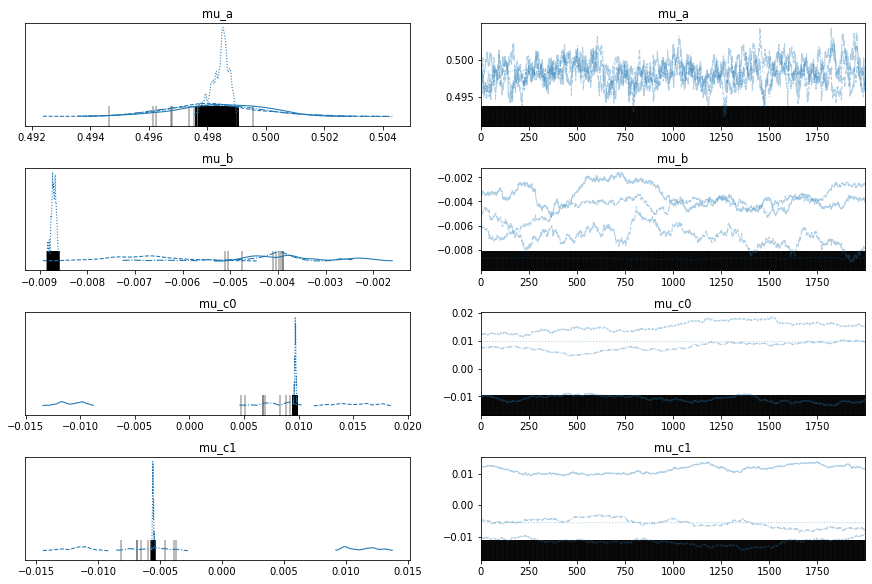

In [82]:
pm.traceplot(hierarchical_trace, var_names=["mu_a", "mu_b", "mu_c0", "mu_c1"]);